# Recommendation System for Opthalmologists

Today you are a Machine Learning Engineer at Epic Software Systems and your task is to develop a new Recommendation System for opthalmologists (eye doctors).

Diabetic Retinopathy (DR) is a pathology that impacts patients with Diabetes Mellitus 2, such that vision is compromised. Base paper on Automated classification of diabetic retinopathy:
https://ieeexplore.ieee.org/abstract/document/6680633

Diabetic Retinopathy classification using modified AlexNet paper: https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190

Paper available at https://drive.google.com/file/d/1nl5tYA2jJ1Up_malA8uQmvwHu6UH0k-r/view?usp=sharing

Automated classification of DR severity can help streamline the treatment process such that patients with higher severity are seen by the doctor first followed by the less severe patiets. This problem of DR clasification is significant since retinal images are biometrics (unique for each individual) which makes generalized modeling difficult and since 90% of the diabetic population that get imaged each year are have NO DR.

This hard problem can be attacked using the tools of Deep Learning. Today we will show you how to use TensorFlow to construct and train a deep learning model on a small amount of DR data. In the clinic we would like to screen patients with different severity levels of the disease: patients that have NO DR (y=0), vs ones with mild DR (y=1), moderate DR (y=2) and severe DR (y=4). However, in this assignment we're going to make it even easier--the model will just do binary classification: normal images (patients without DR) will be labeled y=0, and those with any amount of DR as y=1.

The purpose of this assignment is to show you the mechanics of using TensorFlow, not to say that what we present is the state-of-the-art in DR classification--far from it. But the ideas we use today are the first steps in an ML pipeline that can get quite-good performance in classifying diabetic retinopathy :)

## Task 1: Setup and Load the Data

1. If using Colab, mount your Google Drive.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

2. Load TensorBoard (Optional).

In [2]:
%load_ext tensorboard

3. Setup tensorflow.

In [3]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

#We are using tensorflow_macos

4. The data is stored in the h5 file `1194_DR_smallimages.h5`. h5 stands for Hierarchical Data Format, which is used for multidimensional scientific data. We will use the python module `h5py` to load the data.

    `images` will contain an array of images. Use `plt.imshow` to view a couple of the images to get a sense of what the data looks like.

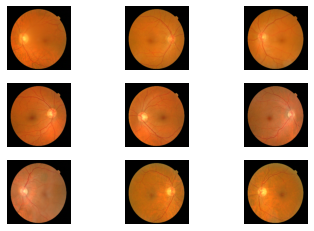

In [4]:
from random import randint
import numpy as np
import h5py
import matplotlib.pyplot as plt

filepath = 'data/1194_DR_smallimages.h5'
f = h5py.File(filepath, 'r')
images = np.array(f['images'])
labels = np.array(f['meta']).squeeze()

for i in range(0, 9):
    plt.subplot(331 + i)
    plt.axis('off')
    plt.imshow(images[i])

5. How many images are in the dataset?

In [5]:
print(len(images))

1194


6. What are the dimensions of the images?

In [6]:
print(images[0].shape)

(227, 227, 3)


7. What are the max and minimum values for the pixel values of the images?

In [7]:
min = np.amin(images)
max = np.amax(images)


8. What are the possible label values for the images?

In [8]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=uint8), array([540, 153, 247, 254]))


## Task 2: Data Exploration and Preprocessing

1. Plot a histogram illustrating the number of images corresponding to each of the 4 DR severity labels.

(array([540.,   0.,   0.,   0., 153.,   0.,   0.,   0., 247.,   0.,   0.,
        254.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  ]),
 <BarContainer object of 12 artists>)

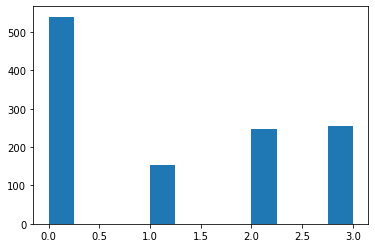

In [9]:
plt.hist(labels, bins = 'auto' )

2. Scale the images' pixel values so they fall in the range [0, 1]. Call the new array of images `images_scaled`. Verify the max and min of im

In [10]:
images_scaled = images / max

3. While our dataset has 4 labels, we will be using just two based on whether they have Diabetic Retinology or not. 0 means they do not while 1-3 are different levels of severity.

    Because of how the model we are using is implemented, we need one hot encoded columns for the labels. So the labels will be a 2D array where the first column is 1 if the patient doesn't have DR and 0 if they do. The second column is the inverse of this: 1 if the patient has DR and 0 if they don't.
    
    Create the `one_hot_labels` array.

In [11]:
one_hot_labels = np.zeros((labels.shape[0], 2))
labels_zero = np.where(labels == 0)[0]
labels_one = np.where(labels != 0)[0]
one_hot_labels[labels_zero, 0] = 1
one_hot_labels[labels_one, 1] = 1

print(one_hot_labels.shape)

(1194, 2)


4. Use scikit-learn's `train_test_split()` function to create the training and test sets with a 2/3 - 1/3 split.

    Name the new arrays `X_train`, `X_test`, `Y_train`, and `Y_test`.
    
    Verify the shapes of the four arrays.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(images_scaled,one_hot_labels, test_size=1/3)

5. Plot a histogram to see the relative distribution of the labels between the training and test sets. Plot the data on either one or two plots.

(array([[354.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 442.],
        [186.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 212.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

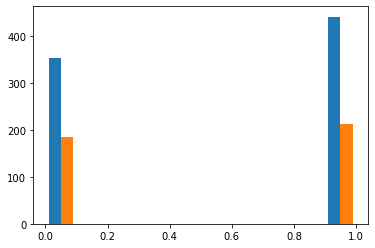

In [13]:
plt.hist([Y_train[:, 1], Y_test[:, 1]], label=['training data', 'test data'])

## Task 3: Model Definition, Classification and Prediction

1. Use the following definition of the `AlexNet` model.

    You can read more about Alex Net [here](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951).

In [14]:
import  tensorflow as tf
print(tf.__version__)

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        print(input_shape)
        self.add(Conv2D(96, kernel_size=(11, 11), strides= 4,
                        padding='valid', activation='relu',
                        input_shape= input_shape, kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None))


        self.add(Conv2D(256, kernel_size=(5, 5), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3, 3), strides= (2, 2),
                              padding='valid', data_format=None))


        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(384, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(Conv2D(256, kernel_size=(3, 3), strides= 1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(BatchNormalization())

        self.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                              padding='valid', data_format=None))


        self.add(Flatten())

        self.add(Dense(num_classes, activation='softmax'))

        self.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

2.8.0


2. Instantiate a model using the `AlexNet` class and save it as `model`.

In [15]:

model = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes=2)

Metal device set to: Apple M1 Pro
(227, 227, 3)


2022-03-08 15:03:12.177024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 15:03:12.177157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


3. Use the `summary()` method to view a summary of the architecture of the model.

In [16]:
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                          

4. Discuss with your classmates your interpretation of this summary. What do these numbers and names represent? (It's okay to speculate.)

- The first line is a convolution layer for a specific batch.
   - None is the batch size
   - 55 and 55 are the size of the resulting image
   - 96 are the number of filters of this convolution and also the number of channels in its output
- Then added a batch_norm for each batch. It keeps the layer coming form  the convulition (Same shape, same filter)
- Then added a maxPooling the (3/3) but with strides (2,2). It divided the size of the image by two, leaving the rest as it was (None,27,27,96)
- Then added a new convolution but with a new filter (256), so the new shape is (None,27,27,256)
- It repeats the same process reducing shape and changing filter.
- The flatten layer, which takes the images and transform them into a single vector, output shape is (None, 9216), where None is still the batch size untouched, the 9216 are all elements that the input tensor had, now in a single vector, one vector per sample in the batch.
- The last layer is a dense layer. In this case is the outlayer with a shape equal to the number of classes

5. Train the model using the `.fit()` method. Save the result as `training_history`.

    Set aside 20% of the data as a validation set. Use a batch size of 20 and train for 40 epochs. Set verbose to True so you get feedback as the model trains.

    Optional: Use TensorBoard to visualize how its properties evolve over the training epochs. To do this, create a log directory and employ a TensorBoard callback. We include code for creating the callback below, but you'll have to pass it in as a parameter o the `.fit()` method.

In [17]:
from tensorflow import keras
from datetime import datetime

logdir = "data/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [18]:
training_history = model.fit(X_train, Y_train, batch_size=20, epochs=40, verbose=True, validation_data=(X_test,Y_test) )
print("Average test loss: ", np.mean(training_history.history['loss']))

Epoch 1/40


2022-03-08 15:03:13.980923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 15:03:14.492725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 11.8885 - accuracy: 0.5151

2022-03-08 15:03:24.281888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 11s 138ms/step - loss: 11.8885 - accuracy: 0.5151 - val_loss: 1243.1044 - val_accuracy: 0.4673
Epoch 2/40
40/40 [==============================] - 4s 89ms/step - loss: 5.6092 - accuracy: 0.4950 - val_loss: 27.4781 - val_accuracy: 0.5352
Epoch 3/40
40/40 [==============================] - 3s 85ms/step - loss: 4.6834 - accuracy: 0.5339 - val_loss: 2.0076 - val_accuracy: 0.5352
Epoch 4/40
40/40 [==============================] - 3s 85ms/step - loss: 2.3070 - accuracy: 0.5327 - val_loss: 0.8603 - val_accuracy: 0.5503
Epoch 5/40
40/40 [==============================] - 4s 88ms/step - loss: 2.7446 - accuracy: 0.5176 - val_loss: 1.6890 - val_accuracy: 0.5327
Epoch 6/40
40/40 [==============================] - 3s 87ms/step - loss: 1.9491 - accuracy: 0.5452 - val_loss: 1.8909 - val_accuracy: 0.5352
Epoch 7/40
40/40 [==============================] - 4s 88ms/step - loss: 1.3049 - accuracy: 0.5477 - val_loss: 1.0843 - val_accuracy: 0.5452
Epoch 8/40
40/40 

6. If you're using Colab, run the following lines to change the working directory to where you have uploaded the `helper_functions_for_week5.py` file.

In [19]:
#import os

#filepath = '/content/drive/My Drive/fourthbrain/'
#os.chdir(filepath)
#pwd = os.getcwd()
#print(pwd)

7. Display loss and accuracy for both the training and validation data.

    Hint: Use the provided functions in `helper_functions_for_week5.py`. 

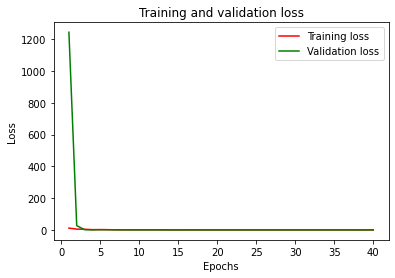

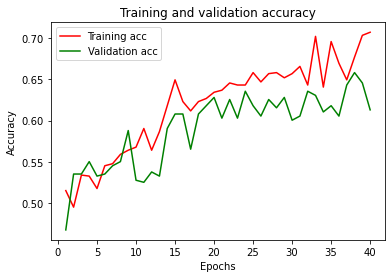

In [20]:
from helper_functions_for_week5  import plot_loss_history, plot_accuracy_history, display_activation

plot_loss_history(training_history.history)
plot_accuracy_history(training_history.history)


8. If you are using tensorboard callbacks, try launching tensorboard to view the logs with one of the following commands:
    
    - If developing locally: `tensorboard --logdir <THIS_DIRECTORY>/logs`
    - If developing on Colab: `%tensorboard --logdir logs`

In [21]:
%tensorboard dev upload --logdir logs \
    --name "(optional) My latest experiment" \
    --description "(optional) Simple comparison of several hyperparameters"

Launching TensorBoard...

9. Generate predictions with the test data and save the values as `prediction_values`.

In [22]:
prediction_values = np.argmax(model.predict(X_test), axis=-1)

2022-03-08 15:05:43.555702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10. Evalute the predictions by calculating the accuracy, precision, recall, f1 score and confusion matrix.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

cmtp=confusion_matrix(Y_test[:, 1], prediction_values)
acc  = accuracy_score(Y_test[:, 1], prediction_values)
rec  = recall_score(Y_test[:, 1], prediction_values)
prec = precision_score(Y_test[:, 1], prediction_values)
f1   = f1_score(Y_test[:, 1], prediction_values)

print(cmtp)
print(acc)
print(rec)
print(prec)
print(f1)

[[ 86 100]
 [ 54 158]]
0.6130653266331658
0.7452830188679245
0.6124031007751938
0.6723404255319149


11. What do you notice about the performance of this model, especially as it relates to the difference between train and validation accuracy?

The model has a low accuracy abut a good precision. If you take  look to the graph, bot line should have less separation between them (less error between training and testing steps). Some strategies to reduce this behaviour could be: * Add more layers or  * Add regularization strategy like data augmentation or dropot layers.

## Task 4: Visualize the Activations.

Source: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

1. Extract the output of each layer in the model and save it as the list `layer_outputs`.

In [24]:
layer_outputs = [layer.output for layer in model.layers]

2. Define a new model `activation_model` with the same input shape as the original model and `layer_outputs` as its outputs.

In [25]:
#from tensorflow.keras.models import Model

activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

3. Get all the activations by calling the `predict()` method on the number 10 image in `X_train`. Note that even though you're passing a single image, you still need to have 4 dimensions (not just the 3 dimensions of the image). Save the result as `activations`.

In [26]:
activations = activation_model.predict(X_train[10][np.newaxis, :])

2022-03-08 15:05:44.345048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4. Display the first 64 activations of the second model layer (layer index 1) in an 8 x 8 grid.

    Hint: Look at the functions `helper_functions_for_week5.py`.

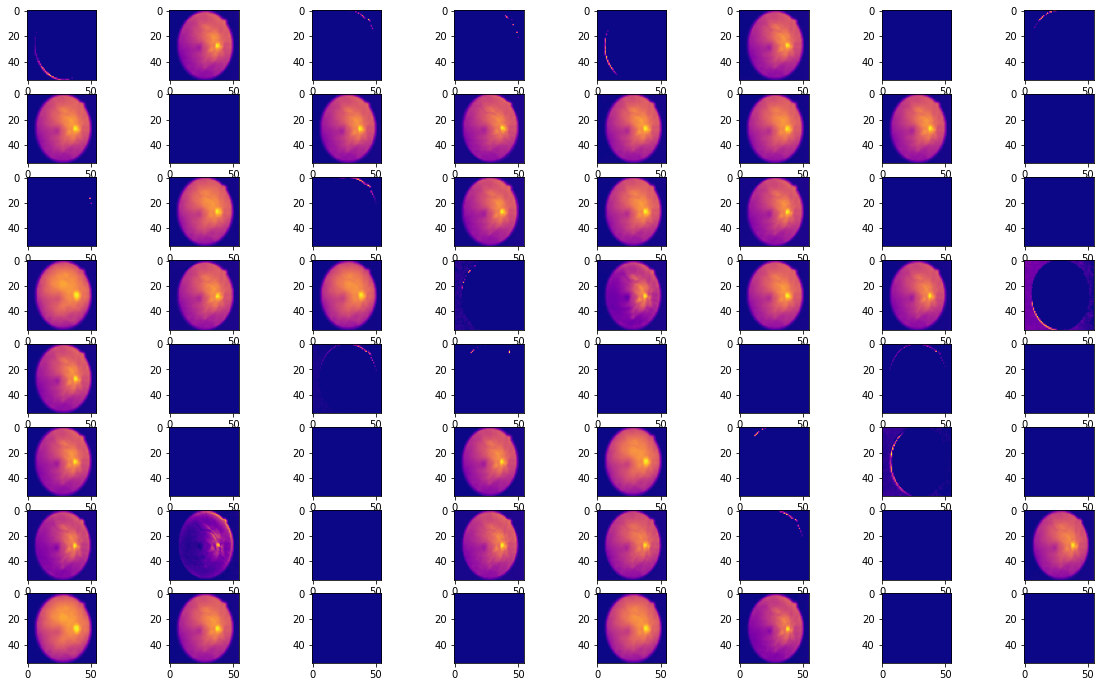

In [27]:
display_activation(activations, 8, 8, 1)

5. Display the first 64 activations of the 11th model layer (layer index 10) in an 8 x 8 grid.

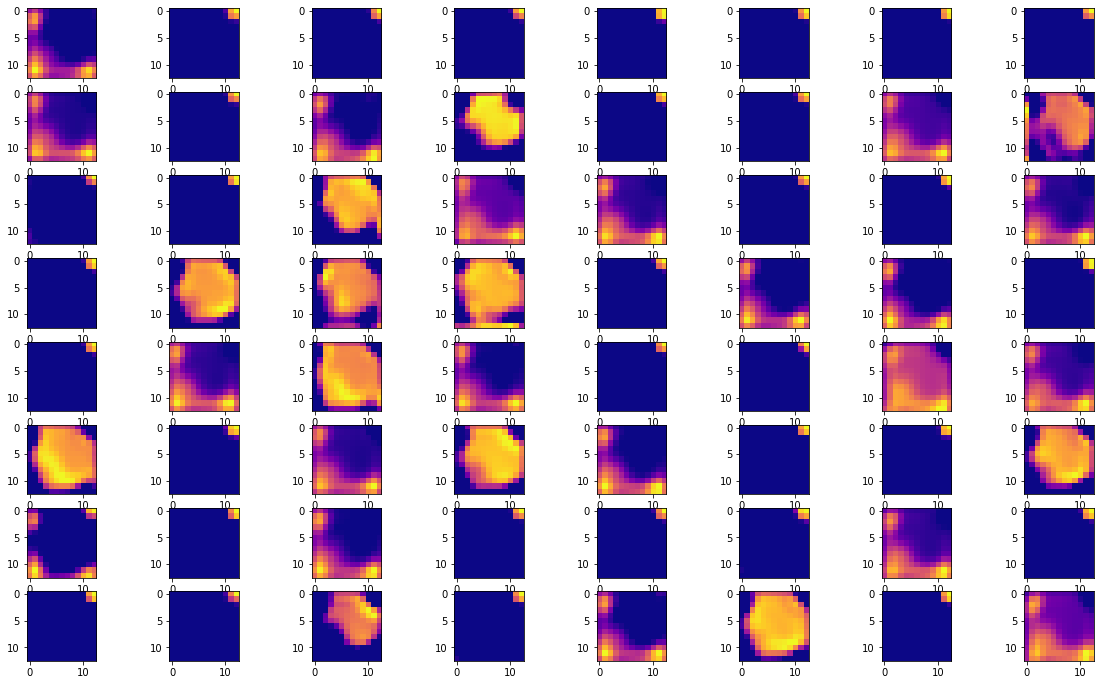

In [28]:
display_activation(activations, 8, 8, 10)

6. Comment on the activated feature maps for early layers and later layers. What patterns do you observe?

**Answer** ---- Both layers have changed the color and saturation of the images, but in  the last layer, the images tend to have distortion and zoom. The edges and shapes are not defined in the last layer

## Task 5: Regularization by Data Augmentation [Instructor Led]

We can regularize our model (and, in doing so, hopefully improve it) by augmenting our image data. Image augmentation includes transformations such as rotation, translation, reflection, shearing, and color permutation. TensorFlow provides the `ImageDataGenerator` class to perform image augmentation in memory; by default, your local storage won't save the newly generated images.

1. Create a Data Generator.

In [29]:
data_gen_args = dict(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
BATCH_SIZE = X_train.shape[0]

2. Initialize data generator for training/validation and test data sets.

In [30]:
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = image_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

3. Set useful parameters.

In [31]:
seed = 0
aug_batch_size = 6

4. View some randomly generated images to gain understanding of the data augmentation process.

Epoch 0
(6, 227, 227, 3)


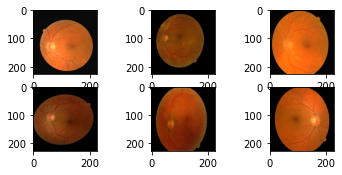

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Epoch 1
(6, 227, 227, 3)


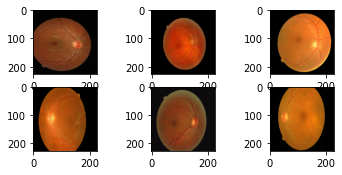

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Epoch 2
(6, 227, 227, 3)


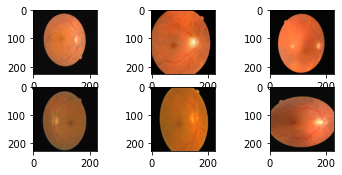

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Epoch 3
(6, 227, 227, 3)


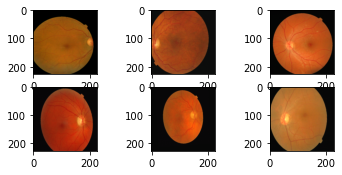

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Epoch 4
(6, 227, 227, 3)


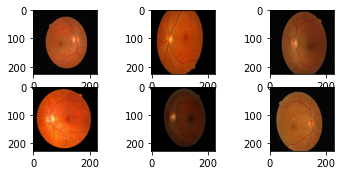

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [32]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        plt.show()
        print(y_batch)
        break

There are two methods for using augemented data to train the model.

### Method 1

5. Iterate through randomized `(X, y)` batches generated by `train_generator` and fit `AlexNet` to each one.

    Note: If you have issues with your Colab instance running out of memory, you may have to delete some previously-created variables such as the `model` object holdig the unregularized version of `AlexNet`.

In [33]:
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes=2)

EPOCHS = 40
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []

for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator:
        reg_hist = (model_reg.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= len(X_train) / BATCH_SIZE:
            break

(227, 227, 3)
Epoch 0


2022-03-08 15:05:55.497304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 17.6651 - accuracy: 0.5204

2022-03-08 15:06:00.267434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 5s 186ms/step - loss: 17.6651 - accuracy: 0.5204 - val_loss: 26048.8418 - val_accuracy: 0.4188
Epoch 1
20/20 [==============================] - 3s 128ms/step - loss: 9.4645 - accuracy: 0.4969 - val_loss: 1676.4746 - val_accuracy: 0.4563
Epoch 2
20/20 [==============================] - 3s 132ms/step - loss: 4.0974 - accuracy: 0.5267 - val_loss: 107.3535 - val_accuracy: 0.4437
Epoch 3
20/20 [==============================] - 3s 128ms/step - loss: 3.5827 - accuracy: 0.5330 - val_loss: 45.5171 - val_accuracy: 0.4750
Epoch 4
20/20 [==============================] - 3s 129ms/step - loss: 4.8922 - accuracy: 0.5409 - val_loss: 10.1229 - val_accuracy: 0.6562
Epoch 5
20/20 [==============================] - 3s 130ms/step - loss: 3.0059 - accuracy: 0.5377 - val_loss: 36.7854 - val_accuracy: 0.5813
Epoch 6
20/20 [==============================] - 3s 128ms/step - loss: 3.1536 - accuracy: 0.5330 - val_loss: 4.0364 - val_accuracy: 0.5750
Epoch 7
20/20 [=======

6. Plot the losses and accuracies for both training and validation data

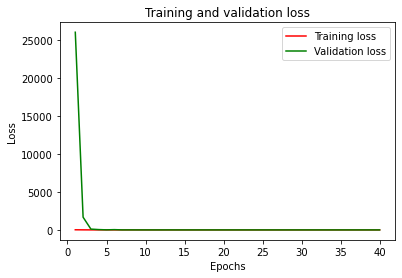

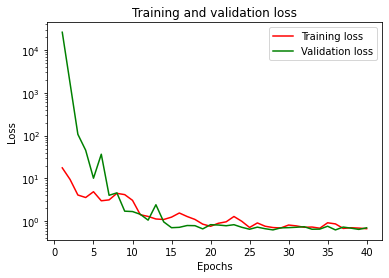

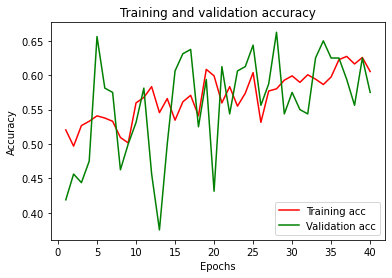

In [34]:
plot_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss})
plot_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss}, logscale=True)
plot_accuracy_history({'accuracy': reg_history_accuracy, 'val_accuracy': reg_history_val_accuracy})

### Method 2:

7. Pass `train_generator` into the model's `fit()` method directly and abstract away the looping.

In [44]:
model_reg_2 = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes=2)
reg_history = model_reg_2.fit(
    train_generator,
    #steps_per_epoch=X_train/40,
    verbose=1, 
    epochs=10,
    validation_data=(X_test, Y_test),
#    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

(227, 227, 3)
Epoch 1/10


2022-03-08 15:15:01.426908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2.8041 - accuracy: 0.5553

2022-03-08 15:15:09.177623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 8s 8s/step - loss: 2.8041 - accuracy: 0.5553 - val_loss: 15732.3516 - val_accuracy: 0.4673
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 60.7682 - accuracy: 0.4447 - val_loss: 592519.1875 - val_accuracy: 0.4673
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 5.1185 - accuracy: 0.4447 - val_loss: 2173203.2500 - val_accuracy: 0.4673
Epoch 4/10
1/1 [==============================] - 8s 8s/step - loss: 63.8548 - accuracy: 0.5553 - val_loss: 10456127.0000 - val_accuracy: 0.4673
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 24.6794 - accuracy: 0.5553 - val_loss: 6113566.0000 - val_accuracy: 0.4673
Epoch 6/10
1/1 [==============================] - 8s 8s/step - loss: 39.3413 - accuracy: 0.4447 - val_loss: 8197021.5000 - val_accuracy: 0.4673
Epoch 7/10
1/1 [==============================] - 8s 8s/step - loss: 20.0586 - accuracy: 0.4447 - val_loss: 4068880.0000 - val_accuracy: 0.4673
Epoch 8

8. Plot the losses and accuracy.

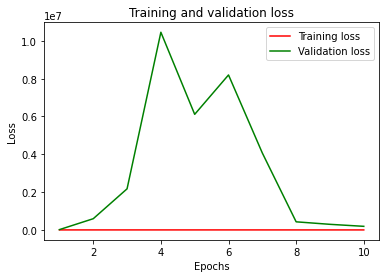

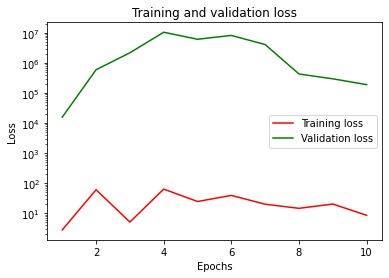

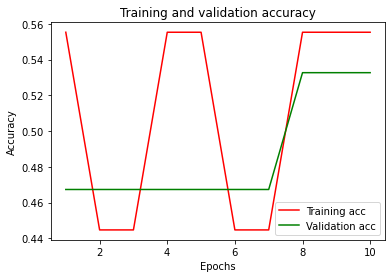

In [45]:
plot_loss_history(reg_history.history)
plot_loss_history(reg_history.history, logscale=True)
plot_accuracy_history(reg_history.history)

9. Save the whole trained model to disk.

In [46]:
model_reg_dir = "data/reg_model.h5"
model_reg.save(model_reg_dir)  # or model_reg_2 if that's the one you trained

In [38]:
# %tensorboard --logdir logs

## Task 6: Evaluate the Regularized Model and Report Results

1. Compute the evaluation metrics for the regularized model.

In [47]:
pred_reg= np.argmax(model_reg_2.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(Y_test[:,1], pred_reg)}')
print(f'F1 = {f1_score(Y_test[:,1], pred_reg)}')
print(f'Precision = {precision_score(Y_test[:,1], pred_reg)}')
print(f'Recall = {recall_score(Y_test[:,1], pred_reg)}')
print('Confusion matrix = ')
confusion_matrix(Y_test[:,1], pred_reg)

2022-03-08 15:17:18.069087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy = 0.5326633165829145
F1 = 0.6950819672131148
Precision = 0.5326633165829145
Recall = 1.0
Confusion matrix = 


array([[  0, 186],
       [  0, 212]])

2. Following the same steps as in Task 4, visualize the activations from layers at index 1 and 10 for the regularized model.

In [48]:
layer_outputs = [layer.output for layer in model_reg_2.layers]
activation_model = tf.keras.models.Model(inputs=model_reg_2.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10][np.newaxis, :])

2022-03-08 15:17:33.920682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


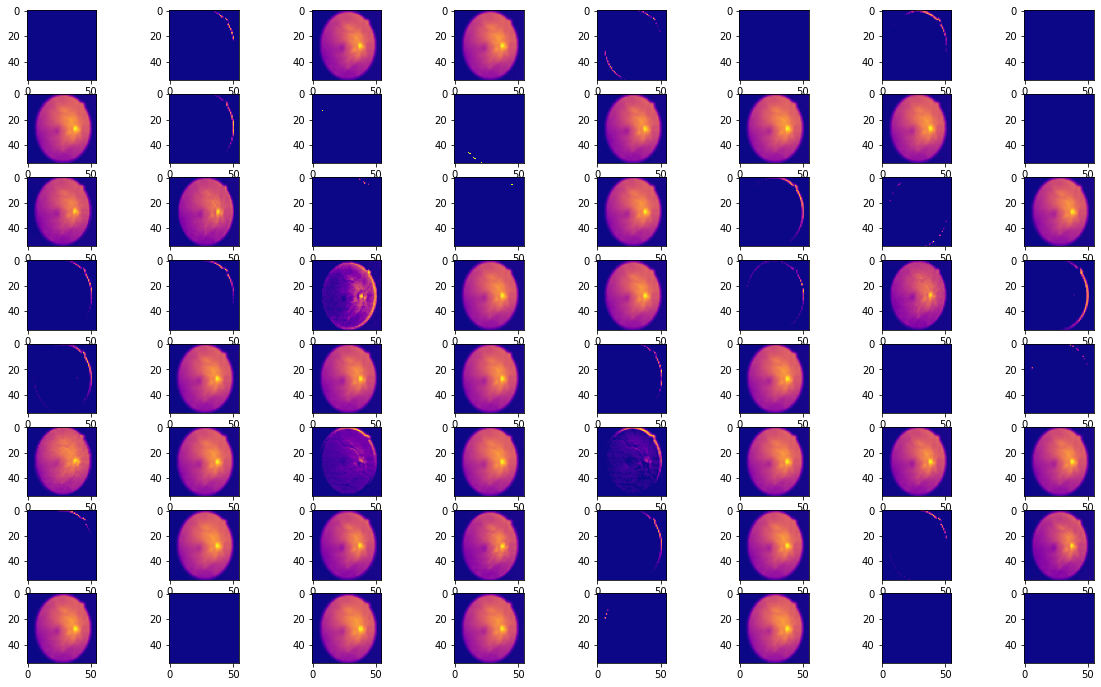

In [49]:
display_activation(activations, 8, 8, 1)

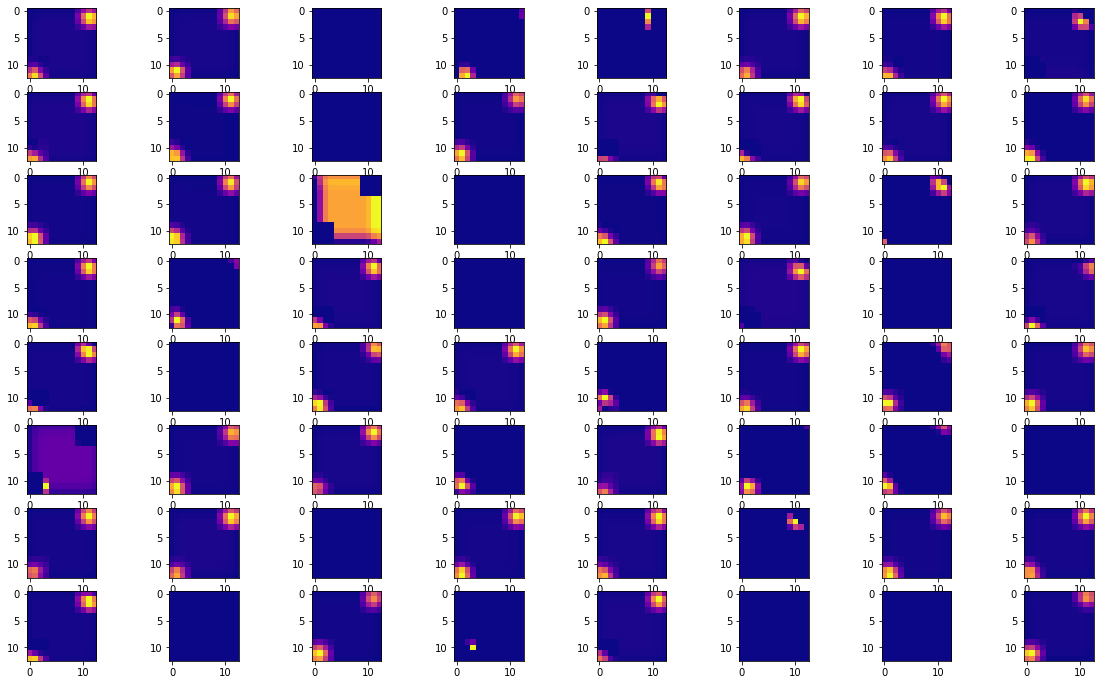

In [50]:
display_activation(activations, 8, 8, 10)